In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 14, 28

In [3]:
from ImageHandler import *
from ImageProcessing import *
from Processing import *

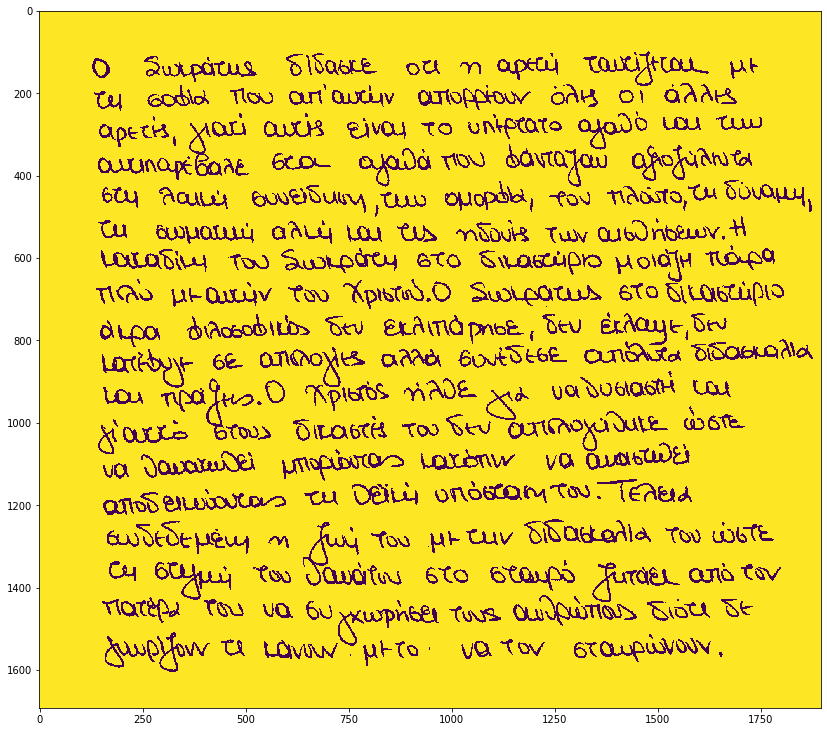

In [106]:
# image = loadImage('Test-data/050200074.jpg');
image = loadImage('../icdar/141.jpg');
(h, w) = np.shape(image);
_, image = cv.threshold(image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(image);

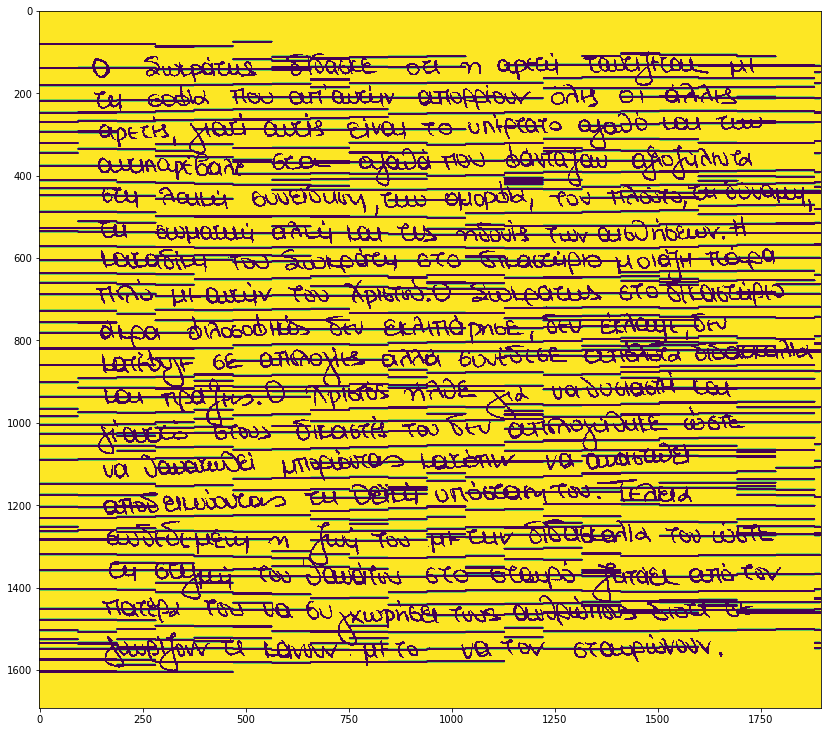

In [107]:
width = int (0.05 * w);
(h, w) = np.shape(image);
strips = (int (w/width) + (1 if w%width != 0 else 0));
M = 3;

wt = getWeights(M);
pp = [];
for i in range(strips):
    pp.append(projectionProfile(image, width, i));

delta = getdelta(image, width, strips, pp);
SPR = [];
for i in range(strips):
    SPR.append(getSPR(image, M, i, delta, wt, pp, strips));
    
dSPR = [];
CCheight = int (getCCHeight(image) / 2);
for i in range(strips):
    dSPR.append(getdiffSPR(SPR[i], image, CCheight));
showLine(image, dSPR, strips, width);

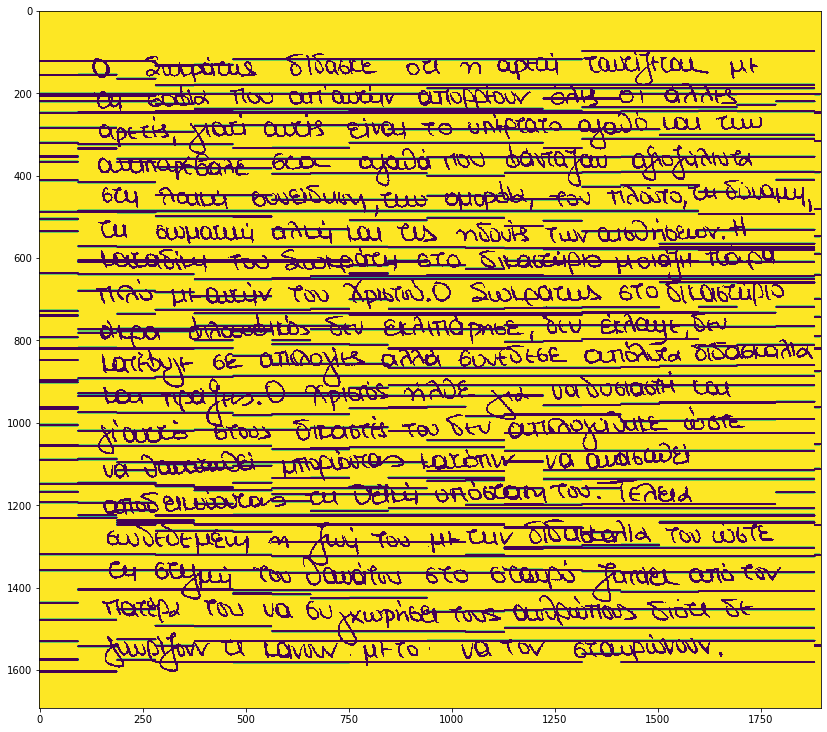

In [145]:
nRegions = applyViterbi(dSPR, strips, pp, width, CCheight, w)

pRegions = [];
for regionsStrip in nRegions:
    pRegionsStrip = [];
    tempRegion = [];
    gap = False
    for region in regionsStrip:
        if region[2] == 0:
            if gap:
                tempRegion[1] += region[1]
            else:
                if tempRegion != []:
                    pRegionsStrip.append(region[0] + int (region[1] / 2));
                tempRegion = region;
                gap = True;
        else:
            gap = False;
    pRegions.append (pRegionsStrip);
textRegions = connectSeparators(pRegions, delta, SPR, h);
showProcessedRegions(image, pRegions, width, w);

* CC is assigned if line cuts with >75% of CC above
* If CC is intersected with 2 lines, extend zone on both direction
* Find where line j are assigned unquestionabbly find Na
* Extend CC into that zone and find Nb and calc ratio
* r<0.4 assign to one with greater overlap, one above r then assign it, both above r then split CC
* Find junction point using paper given

In [146]:
labels = [];
stats = [];
centroids = [];
for i in range(strips):
    imageStrip = image[:,i*width : (i+1)*width if (i+1)*width < w else w];
    if delta[i] == 1:
        labelStrip, statStrip, centroidStrip = getCC(imageStrip);
    else:
        labelStrip, statStrip, centroidStrip = [], [], [];
    print (len(statStrip), end = ' ')
    labels.append(labelStrip);
    stats.append(statStrip);
    centroids.append(centroidStrip);

0 53 99 112 104 91 95 118 128 96 98 113 109 102 103 145 122 93 61 0 0 

In [151]:
chosenLines = [];
for i in range(strips):
    chosenLinesStrip = [];
    for j in range(len(stats[i])):
        stat = stats[i][j]
        if (len (stat) == 0):
            break;
        lines = getLineinRange(pRegions[i], stat[1], stat[1] + stat[3]);
        print (lines)
        th75 = stat[1] + stat[3];
        lines = [line for line in lines if line > th75];
        lines = checkDuplicacy(chosenLinesStrip, lines);
        if len(lines) > 1:
            print ("Ex reqd");
            lines = [lines[0]]
        chosenLinesStrip.extend(lines);
    chosenLines.append(chosenLinesStrip);

[123, 156, 202, 207, 221, 248, 285, 325, 335, 336, 417, 486, 487, 489, 572, 606, 609, 610, 640, 680, 782, 818, 773, 819, 820, 892, 929, 935, 975, 1019, 1056, 1087, 1089, 1145, 1146, 1147, 1148, 1194, 1224, 1230, 1231, 1319, 1358, 1404, 1405, 1478, 1542, 1603]
[123, 156]
[123, 156]
[]
[202, 207, 221]
[202, 207, 221]
[]
[]
[285]
[285]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[606, 609, 610]
[]
[]
[680]
[680]
[]
[782, 773]
[]
[782, 773]
[]
[782, 773]
[]
[]
[]
[]
[929, 935]
[]
[1019, 1056]
[1056]
[]
[]
[]
[1194]
[1194]
[]
[]
[]
[1358]
[1358]
[]
[1542]
[]
[1542]
[]
[123, 166, 202, 207, 221, 248, 295, 325, 360, 368, 417, 486, 487, 490, 573, 606, 609, 610, 640, 680, 736, 772, 773, 774, 778, 820, 892, 929, 935, 976, 1019, 1056, 1096, 1115, 1145, 1146, 1147, 1148, 1194, 1212, 1237, 1242, 1247, 1319, 1358, 1404, 1405, 1452, 1525, 1575]
[]
[123]
[]
[]
[123]
[]
[]
[207, 221]
[207, 221]
[207, 221]
[221]
[221]
[]
[295]
[295]
[295, 325]
[295]
[295]
[]
[]
[]
[360, 368]
[368]
[]
[]
[]
[]
[]
[]
[606, 609, 610]
[606, 

[773]
[820]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[935, 984]
[935]
[]
[984]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1364]
[1364]
[1364]
[1364]
[]
[]
[1457]
[1457]
[]
[1457]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[119, 181, 189, 239, 244, 248, 289, 321, 356, 394, 458, 486, 487, 523, 577, 607, 642, 643, 645, 651, 722, 735, 738, 764, 804, 867, 886, 909, 934, 980, 1025, 1068, 1094, 1159, 1197, 1199, 1207, 1223, 1224, 1225, 1254, 1302, 1305, 1324, 1356, 1406, 1455, 1497, 1528, 1580]
[119]
[119]
[]
[]
[]
[]
[]
[]
[]
[289]
[289]
[]
[289]
[289]
[]
[]
[289]
[356]
[356]
[356]
[356]
[356]
[356]
[356]
[]
[]
[458]
[458]
[]
[458]
[]
[458]
[458]
[]
[458, 486, 487]
[]
[]
[]
[]
[]
[607]
[607]
[]
[]
[607]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[764]
[]
[]
[]
[]
[]
[]
[]
[]
[934]
[934]
[934]
[980]
[980]
[1025]
[1025]
[1025]
[]
[1094]
[1159]
[1159]
[1159]
[1159]
[]
[1254]
[]
[]
[]
[1356]
[]
[]
[1356]
[1356]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1455]
[1455]
[1455]
[]
[]
[1528]
[]
[]
[]
[]
[119, 181, 189, 214, 2

In [150]:
chosenLines

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

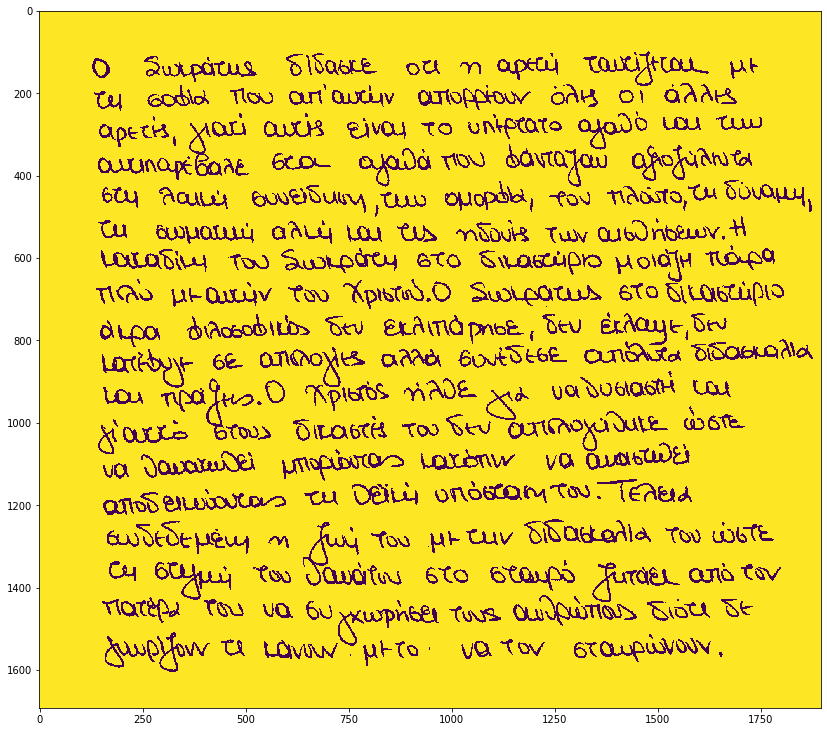

In [149]:
showProcessedRegions(image, chosenLines, width, w)

In [144]:
max([len(strip) for strip in chosenLines])

0

In [40]:
[1,2,3][3:]

[]

In [50]:
int(np.shape(image)[0]/80)

15

In [132]:
# def getLineinRange(regionsStrip, top, bottom):
#     lines = [];
#     for region in regionsStrip:
#         if region > top and region < bottom:
#             lines.append(region);
#     return lines;

# def getStatsAroundLine(line, stats, i):
#     chosen = [];
#     for stat in len(stats[i]):
#         if stat[1] < line and stat[1] + stat[3] > line:
#             chosen.append(stat);
#     return chosen;
        
# def checkDuplicacy(chosenLinesStrip, lines):
#     unique = [];
#     for line in lines:
#         if line not in chosenLinesStrip:
#             unique.append(line);
#     return unique;
    
# def extendZone(pRegions, i, stats, top, bottom, lines):
#     pos = findPosofLine(pRegions[i], lines);
#     for diff in range(1, len(pRegions)):
#         if i - diff > 0:
#             resolvedLine = resolveConflict(image, pRegions, i - diff, stats, top, bottom, lines);
#             if len(resolvedLine) != 0:
#                 return resolvedLine;
#         if i + diff < len(pRegions):
#             if len(resolvedLine) != 0:
#                 return resolvedLine;
#     return [];

# def resolveConflict(image, pRegions, pos, stats, top, bottom, lines):
#     resolvedLine = [];
#     for line in lines:
#         chosenStats = getStatsAroundLine(line, stats, pos);
#         for stat in chosenStats:
#             linesinRange = getLineinRange(pRegions[pos], stat[1], stat[1] + stat[3]);
#             th75 = stat[1] + (0.75 * stat[3]);
#             linesinRange = [line for line in linesinRange if line > th75];
#             if len(linesinRange) == 1:
#                 resolvedLine = getResolvedLine(image, stat, top, bottom, linesinRange, lines);
#                 return resolvedLine;
#     return resolvedLine;

# def getResolvedLine(image, stat, top, bottom, lineinRange, lines):
#     na = [];
#     nb = [];
    
#     for line in lines:
        